## The project has function to detect object in an image

Ref: https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#LIB
import cv2
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import joblib

In [4]:
#CONSTANT parameter
IMAGE_SIZE = (224, 224)
EPOCHS = 50

In [5]:
def get_iou(bb1, bb2):
  '''Calculate iou (interception over union) metric which is used for 
  object detection problem'''
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']

  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max( bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bottom = min( bb1['y2'], bb2['y2'])

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  interception_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

  iou = interception_area / (bb1_area + bb2_area - interception_area)

  assert iou >= 0.0
  assert iou<=1
  
  return iou

In [7]:
#selective search, ref: https://learnopencv.com/selective-search-for-object-detection-cpp-python/
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [8]:
THRESHOLD=0.7 #to define match between regions (from selective search) and ground truth bbox
annotation_folder = "/content/drive/MyDrive/Airplane_detection/dataset/Airplanes_Annotations"

image_folder = '/content/drive/MyDrive/Airplane_detection/dataset/Images'

model_folder = '/content/drive/MyDrive/Colab Notebooks/Airplane_detection/models'

train_images = []
train_labels = []

all_files = os.listdir(annotation_folder)
random.shuffle(all_files)
for e, i in enumerate(all_files):
  # try:
    if e>500:
      break

    if i.startswith('airplane'):
      image_name = i.split('.') [0] +".jpg"
      print(e, image_name)

      image = cv2.imread(os.path.join(image_folder, image_name))
      
      df = pd.read_csv( os.path.join(annotation_folder, i))

      groundtruth_values = []

      for row in df.iterrows(): #ignore the first row indicating number of objects
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])

        groundtruth_values.append({"x1":x1, "x2":x2, "y1":y1, "y2": y2})
        #use the selective search algorithm
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ss_results = ss.process()
        imout = image.copy()

        counter =0
        falsecounter = 0
        flag=0
        fflag = 0
        bflag = 0

        #get 2000 boxes
        for e, result in enumerate(ss_results):
          if  e<2000 and flag == 0:
            for gtval in groundtruth_values:
              # print(gtval)
              x, y, w, h = result
              iou = get_iou(gtval, {"x1": x, "x2": x+w, "y1":y, "y2":y+h})
              
              if counter <5: #get 5 samples of positive samples
                if iou >THRESHOLD: #positive image (iou > THRESHOLD)
                  timage = imout[y:y+h, x:x+h]
                  #create a new image for training set
                  resized = cv2.resize(timage, IMAGE_SIZE )

                  train_images.append(resized)
                  train_labels.append(1) # 1 to indicate for positive image (airplane)
                  counter += 1
              else:
                  fflage=1

                #get 5 negative samples (not contain airplane)
              if falsecounter <5:
                if iou<0.3:
                  timage = imout[y:y+h, x:x+w]
                  resized = cv2.resize(timage, IMAGE_SIZE)

                  train_images.append(resized)
                  train_labels.append(0)

                  falsecounter += 1
              else:
                  bflag = 1
            if fflag ==1 and blag ==1:
              print("inside")
              flag=1
  # except Exception as e:
  #   print(e)
  #   print("error in "+ image_name)
  #   continue
            



0 airplane_347.jpg
1 airplane_239.jpg
2 airplane_527.jpg
3 airplane_109.jpg
4 airplane_477.jpg
5 airplane_346.jpg
6 airplane_024.jpg
7 airplane_517.jpg
8 airplane_676.jpg
9 airplane_668.jpg
10 airplane_005.jpg
11 airplane_662.jpg
12 airplane_536.jpg
14 airplane_264.jpg
15 airplane_104.jpg
16 airplane_038.jpg
17 airplane_199.jpg
18 airplane_236.jpg
20 airplane_694.jpg
21 airplane_537.jpg
22 airplane_343.jpg
23 airplane_575.jpg
24 airplane_359.jpg
25 airplane_260.jpg
26 airplane_310.jpg
27 airplane_141.jpg
28 airplane_369.jpg
29 airplane_278.jpg
30 airplane_378.jpg
31 airplane_366.jpg
32 airplane_046.jpg
33 airplane_026.jpg
34 airplane_582.jpg
35 airplane_180.jpg
36 airplane_030.jpg
37 airplane_535.jpg
38 airplane_566.jpg
39 airplane_474.jpg
40 airplane_283.jpg
42 airplane_041.jpg
43 airplane_160.jpg
44 airplane_321.jpg
45 airplane_266.jpg
47 airplane_114.jpg
48 airplane_414.jpg
49 airplane_279.jpg
50 airplane_652.jpg
51 airplane_473.jpg
52 airplane_599.jpg
53 airplane_056.jpg
54 airplan

In [9]:
print("number of samples: ", len(train_labels))
print('number of samples having positive sample', train_labels.count(1))

number of samples:  13502
number of samples having positive sample 6072


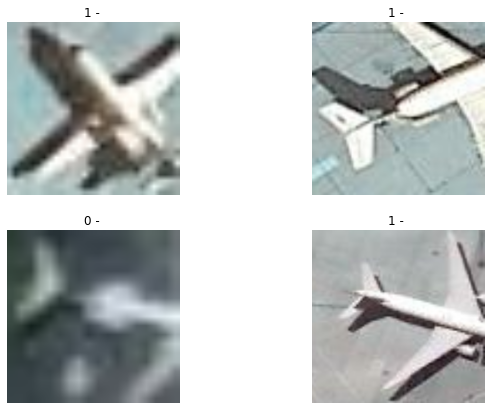

In [13]:
#show serveral images  
fig = plt.figure(figsize=(10, 7))

#set numbers of rows and columns
rows = 2
cols = 2

for i in range(1, rows * cols +1):
  #add a subplot
  fig.add_subplot(rows, cols, i)

  #select an image randomly
  img_index = random.randint(0, len(train_images))
  
  plt.imshow(train_images[img_index])
  plt.axis('off')
  plt.title( str(train_labels[img_index])+" - ")


In [14]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

#split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new,
                                                      test_size = 0.2)


In [19]:
new_train =1
continue_train = 0
test = 0

#callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

save_the_best_model_cb = keras.callbacks.ModelCheckpoint(model_folder+"/model_2_binary_classification.h5", 
                                                           monitor='val_loss', 
                                                          save_best_only=True)

lr_scheduler= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                      patience = 3)
  
#training from scratch
if new_train:
  #use VGG16 model to do transfer learning
  vgg16_model = keras.applications.VGG16(weights='imagenet', include_top= True)

  for layers in (vgg16_model.layers)[:15]:
    layers.trainable = False 


  X = vgg16_model.layers[-2].output
  adding_fc1 = keras.layers.Dense(2048, activation='relu')(X)
  adding_fc2 = keras.layers.Dense(1024, activation = 'relu')(adding_fc1)
  adding_fc3 = keras.layers.Dense(512, activation = 'relu')(adding_fc2)
  predictions = keras.layers.Dense(1, activation='sigmoid')(adding_fc3)
  final_model = keras.models.Model(inputs= vgg16_model.input, outputs = predictions)

  final_model.summary()

  final_model.compile(loss = keras.losses.binary_crossentropy,
                                optimizer= keras.optimizers.Adam(learning_rate=0.0001),
                                metrics = ['accuracy'])
  
 
  history = final_model.fit(X_train, y_train, epochs = EPOCHS,
                            validation_data = (X_valid, y_valid),
                            callbacks =[early_stopping_cb, save_the_best_model_cb,
                                        lr_scheduler])
  
  history = history.history
  joblib.dump(history, model_folder+"/history")

#train continue with exiting model
if continue_train:
  model = keras.models.load_model(model_folder+"/model.h5")

  model.summary()

  model.compile(loss = 'sparse_categorical_crossentropy',
                                 optimizer= keras.optimizers.Adam(learning_rate=0.0001),
                                 metrics = ['accuracy'])
  model.fit(X_train, y_train, epochs = EPOCHS,
            validation_data = (X_valid, y_valid),
            callbacks =[early_stopping_cb, save_the_best_model_cb, lr_scheduler])




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [20]:
model = keras.models.load_model(model_folder+"/model_2_binary_classification.h5")
model.summary()

OSError: ignored

[[0.9985468]]
[[1.]]
[[0.9581185]]
[[0.9930782]]
[[0.9628871]]
[[0.9680359]]
[[0.99890435]]
[[0.9821499]]
[[0.99819934]]
[[0.9999993]]
[[0.9251773]]
[[0.97614753]]
[[0.9999988]]
[[0.9998591]]
[[0.9986204]]
[[0.9991007]]
[[0.9921745]]


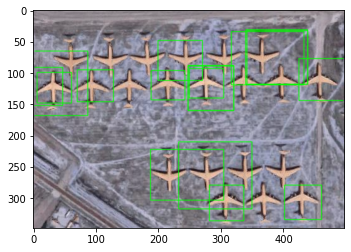

In [32]:
z=0
for e,i in enumerate(os.listdir(image_folder)):
    if i.startswith("Planes9.jpg"):
        z += 1
        img = cv2.imread(os.path.join(image_folder,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model.predict(img)
                if out > 0.9:
                    print(out)
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

        plt.figure()
        plt.imshow(imout)
        break